## Imports

In [1]:
import numpy as np
import csv, os
from os.path import join
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from skimage.registration import phase_cross_correlation
import math
from sympy import symbols, Eq, solve

# Helper Functions

In [2]:
def get_rotation_matrix_inverse(angle: float):
    '''
    Input: Delta Rotation of the the stage in radians\n
    Output: Matrix of the shape:\n
    (2 - 2*cos(phi)) ** (-1) *  [ 1-cos(phi) , -sin(phi) ; sin(phi) , 1-cos(phi) ]
    '''    
    c,s = np.cos(angle), np.sin(angle)
    determinant = (2. - 2. * np.cos(angle)) ** -1
    matrix = np.matrix([[1.0 - c, -s], [ s, 1.0 - c]])
    return(determinant * matrix)

def get_rotation_matrix_offset(angle, origin = (0,0)):
    '''
    Input: Delta Rotation of the the stage in radians, Tuple of rotation center\n
    Output: npmy rotation Matrix 3x3
    '''
    c,s = np.cos(angle), np.sin(angle)
    x,y = origin[0], origin[1]
    matrix = np.array([[c, -s, x - c*x + s*y],[s , c,  y - s*x - c*y],[0,0,1]])
    return(matrix)

def phase_correlate(image_8bit, template_8bit, upsample_factor=25):

    # Determine image sizes
    image_height, image_width = image_8bit.shape
    template_height, template_width = template_8bit.shape
    target_height = max(image_height,template_height)
    target_width = max(image_width,template_width)

    # Pad to largest dimensions
    image_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    image_8bit_pad[0:image_height,0:image_width] = image_8bit
    template_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    template_8bit_pad[0:template_height,0:template_width] = template_8bit

    try:
        # Phase correlation with upsampled matrix-multiplication DFT
        shift, error, diffphase = phase_cross_correlation(template_8bit_pad, image_8bit_pad,upsample_factor=upsample_factor)
        match_center_x = template_width / 2 - shift[1]
        match_center_y = template_height / 2 - shift[0]
        transform = np.float32([ [1,0,shift[1]], [0,1,shift[0]] ])
    except NameError:
        # Phase correlation with Hanning window function and 5x5-weighted centroid around peak
        retval, response = cv2.phaseCorrelate(np.float32(template_8bit_pad), np.float32(image_8bit_pad))
        match_center_x = template_width / 2 + retval[0]
        match_center_y = template_height / 2 + retval[1]
        transform = np.float32([ [1,0,-retval[0]], [0,1,-retval[1]] ])
    image_8bit_pad_shifted = cv2.warpAffine(image_8bit_pad, transform, (target_width,target_height) )
    match_score = float(cv2.matchTemplate(template_8bit_pad, image_8bit_pad_shifted, cv2.TM_CCOEFF_NORMED)[0][0])

    return match_center_x, match_center_y, match_score

def printPositionNicely(p):
    print('Position / mm:\nx: {}\ny: {}\nz: {}\nt: {}\nr: {} {}'.format( \
        round(p['x']*1e3,4), round(p['y']*1e3,4), \
        round(p['z']*1e3,4), round(p['t']*57.2968,2),\
        round(p['r']/math.pi * 180 -360,2), \
        round(p['r']/math.pi * 180,2)))

# Load Sample Images and Data from Server

In [20]:
folder = '//samba-pool-plitzko2.biochem.mpg.de/pool-plitzko2/Johann/03-data/06-FIB-SEM/220922_MeteorAutomation/220922_152312_2.5deg_10_MovementTest/'
file = os.path.join(folder, 'position_data.csv')

In [99]:
try: 
    with open(file, mode='r') as f:
        reader = csv.DictReader(f)
        positions_str = list(reader)


    positions = [dict([a, float(x)] for a, x in b.items()) for b in positions_str]
    #print(positions)
    print(positions[0])
    #for i in range(len(positions)):
    #    print(positions[0])
    print(positions[0]['r']/math.pi*180 -360)
except: 
    print('Didn\'t work')
    pass

position_standard = {}
position_standard['x'] = -2.1915e-3
position_standard['y'] = -4.3908e-3
position_standard['z'] = 6.9725e-3
position_standard['t'] = 0.0
position_standard['r'] = 2*math.pi
positions_sorted = sorted(positions, key=lambda d: d['r']) 
print(positions_sorted)

Didn't work
[{'x': -0.0021406250000003332, 'y': -0.0043809999999999995, 'r': 5.846893532730599, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.03200255821753388, 'y': -0.009353584988345192, 'r': 5.89040034329074, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.02603154038132708, 'y': -0.007795206774801789, 'r': 5.934076969661027, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.022159406954111793, 'y': -0.007411033681896002, 'r': 5.9778215223553754, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.02253447695543353, 'y': -0.007416866945175572, 'r': 6.020581143350858, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.013035878354249904, 'y': -0.0063361976644756976, 'r': 6.056242463482126, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.009080886240695078, 'y': -0.00610175138930495, 'r': 6.065038922447835, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.006949369717621911, 'y': -0

In [22]:
files = []
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        if file.startswith('raw'):
            files.append(file)
            print(file)

raw_image_0.0deg.jpg
raw_image_10.0deg.jpg
raw_image_12.5deg.jpg
raw_image_15.0deg.jpg
raw_image_17.5deg.jpg
raw_image_2.5deg.jpg
raw_image_20.0deg.jpg
raw_image_22.5deg.jpg
raw_image_5.0deg.jpg
raw_image_7.5deg.jpg


# Specify the rotation angle

In [6]:
angle = 5.0
r = np.deg2rad(angle)

# Some obsolete calculations about rotation

# Load the corresponding reference and alignment image at the specified angle

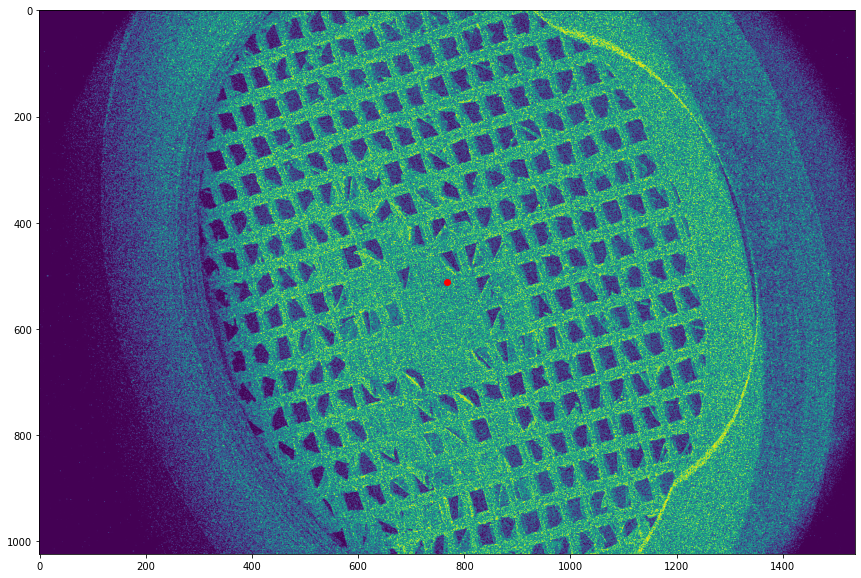

In [7]:
file_reference = [f for f in files if '_0.0' in f]
img_reference = cv2.imread(os.path.join(folder,file_reference[0]),cv2.IMREAD_GRAYSCALE)
plt.imshow(img_reference)
plt.plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')

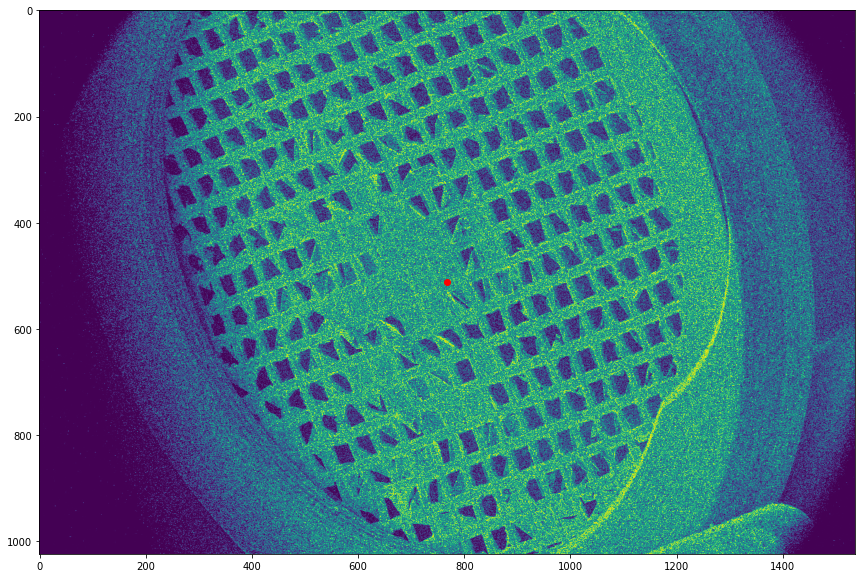

In [8]:
file_alignment = [f for f in files if '_'+ str(angle) in f]
img_alignment = cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_alignment)
plt.plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')

# Calculate the pixel size with the known HFW of 3mm

In [9]:
pixel_size = 3e-3 / img_alignment.shape[0]
print("Pixel Size / micron: {}".format(pixel_size * 1e6))

Pixel Size / micron: 2.9296875


# Detect image features by ORB (Oriented FAST and Rotated Brief)

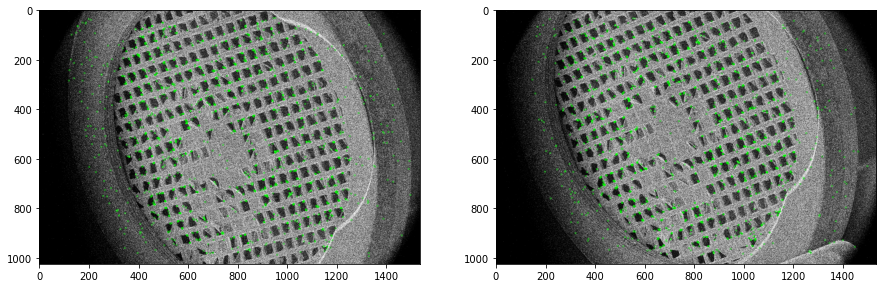

In [10]:
def detect_and_plot(image, axes,N_FEATURES=2000):
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp, des = orb.detectAndCompute(image, None)
    kp_img = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=0)
    axes.imshow(kp_img)


fig, axes = plt.subplots(1,2)
detect_and_plot(img_reference,axes[0])
detect_and_plot(img_alignment, axes[1])

# Match features of 0° and the above specified angle images
## Helper function and execution

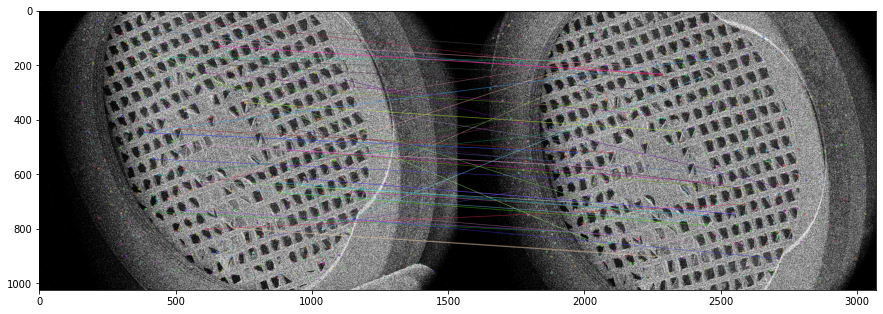

In [11]:
def matchFeatures(img_to_align, img_reference, MIN_MATCHES=50, N_FEATURES=2000, DISPLAY_MATCHES=False):
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(img_to_align, None)
    kp2, des2 = orb.detectAndCompute(img_reference, None)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # As per Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCHES:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        mat, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        corrected_img = cv2.warpPerspective(img_to_align, mat, (img_reference.shape[1], img_reference.shape[0]))
        if DISPLAY_MATCHES:            
            match_img = cv2.drawMatches(img_to_align, kp1, img_reference, kp2, good_matches[:50], None)
            f, ax = plt.subplots()
            ax.imshow(match_img)
            plt.show()

        return corrected_img, mat.copy()
    else:
        print('Matching failed')
        return None, None
        
corrected_img, transformationMatrix = [], []
corrected_img, transformationMatrix = matchFeatures(img_reference=img_reference, img_to_align= img_alignment, DISPLAY_MATCHES=True)

## Plot the results

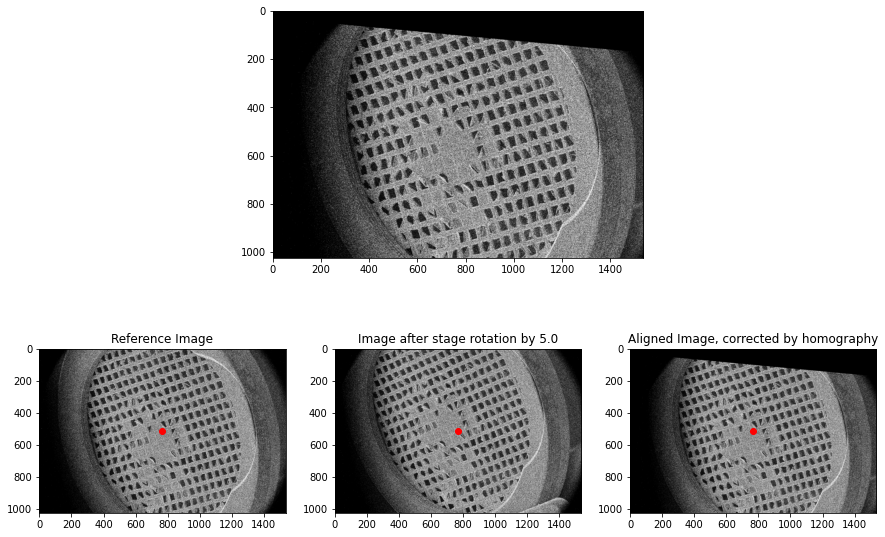

In [12]:
if corrected_img is not None:
    fig, axarr = plt.subplot_mosaic("AAA;BCD")
    axarr["A"].imshow(corrected_img, cmap='gist_gray') 
    axarr["B"].imshow(img_reference, cmap='gist_gray') 
    axarr["B"].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
    axarr["B"].set_title('Reference Image')
    axarr["D"].imshow(corrected_img, cmap='gist_gray') 
    axarr["D"].plot(corrected_img.shape[1]/2, corrected_img.shape[0]/2,'ro')
    axarr["D"].set_title('Aligned Image, corrected by homography')
    axarr["C"].imshow(img_alignment, cmap='gist_gray') 
    axarr["C"].plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')
    axarr["C"].set_title('Image after stage rotation by ' + str(angle))
    plt.show()

## Calculate the translation, scaling and rotation vector from the transformation matrix

In [13]:
def get_params_from_transformation_matrix(m, pixe_size=0.0, PRINT=False):
    if np.abs(m[2,0]) > 1e-3 or np.abs(m[2,1]) > 1e-3 :
        print("This is no valid transformation matrix, the projection component is too large.")
        return None
    else:
        a,b,c,d = m[0,0] , m[0,1], m[1,0], m[1,1]
        result = {}
        result['t'] = [m[0,2], m[1,2]]
        sx, sy = np.sqrt(a ** 2 + c ** 2) , np.sqrt(b ** 2 + d ** 2)
        result['s']  = [sx, sy]
        phi1,phi2 = np.rad2deg(np.arctan((c/sx)/(d/sy))), np.rad2deg(np.arctan((-b/sy)/(a/sx)))
        result['phi']  = [phi1,phi2, np.mean([phi1,phi2])]
        result['t_meter'] =[ t * pixel_size for t in result['t']]           
        x , y = symbols('x,y')
        a = np.deg2rad(result['phi'][2])
        Eq1 = Eq((1 - np.cos(a)) * x - y * np.sin(a) + result['t_meter'][1],0)
        Eq2 = Eq(x * np.sin(a) + (1- np.cos(a)) * y  - result['t_meter'][0],0)
        solution = solve((Eq1,Eq2), (x, y))
        result['c_x'], result['c_y'] = solution[x], solution[y]

        if PRINT:                        
            print("---Image Transformation---")
            print("{}\n".format(m))
            if pixel_size > 0.0:         
                print("Translation (x,y) / mm: {:.2f}, {:.2f}".format(m[0,2]*1e3*pixel_size,m[1,2]*1e3*pixel_size))
            print("Translation (x,y) / px: {}, {}".format(m[0,2],m[1,2]))
            print("Scaling (x,y): {}, {}".format(result['s'][0], result['s'][1]))
            print("Rotation Angle (x,y, mean): {}, {}, {}".format(phi1,phi2 ,round(result['phi'][2],2)))            
            print("Center of rotation / mm: {}, {}".format(solution[x]*1e3, solution[y]*1e3))
        return result


params = get_params_from_transformation_matrix(transformationMatrix, pixe_size=pixel_size, PRINT=True)

#from transforms3d import affines
#affines.decompose(transformationMatrix[1])



---Image Transformation---
[[ 9.94130099e-01 -9.68222002e-02  9.59413293e+01]
 [ 9.30486654e-02  9.85226720e-01  4.18248756e+01]
 [ 3.59646297e-07 -9.38128122e-06  1.00000000e+00]]

Translation (x,y) / mm: 0.28, 0.12
Translation (x,y) / px: 95.94132928520358, 41.82487562278657
Scaling (x,y): 0.9984751911423502, 0.9899728424308002
Rotation Angle (x,y, mean): 5.34955976748209, 5.610186459310125, 5.48
Center of rotation / mm: 2.87535428517085, 1.42073620472385


In [14]:
cv2.getRotationMatrix2D((-42.797,96.622), -5.46, 1)

array([[ 0.99546287, -0.09515081,  8.99948626],
       [ 0.09515081,  0.99546287,  4.51055607]])

# Loop alignment over first 10° in 2.5° steps



Rotation: 2.5


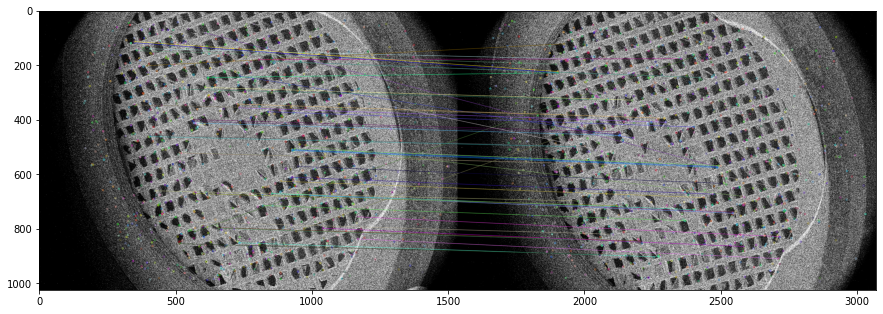

---Image Transformation---
[[ 1.00154584e+00 -4.50596891e-02  4.37449985e+01]
 [ 4.62641282e-02  9.98754969e-01  1.98798586e+01]
 [-1.93951204e-07  9.21259851e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.13, 0.06
Translation (x,y) / px: 43.74499852619481, 19.87985856681429
Scaling (x,y): 1.0026138008801901, 0.9997709057296388
Rotation Angle (x,y, mean): 2.644638398380779, 2.5833232194949103, 2.61
Center of rotation / mm: 2.77950958759202, 1.34045811034958


Rotation: 5.0


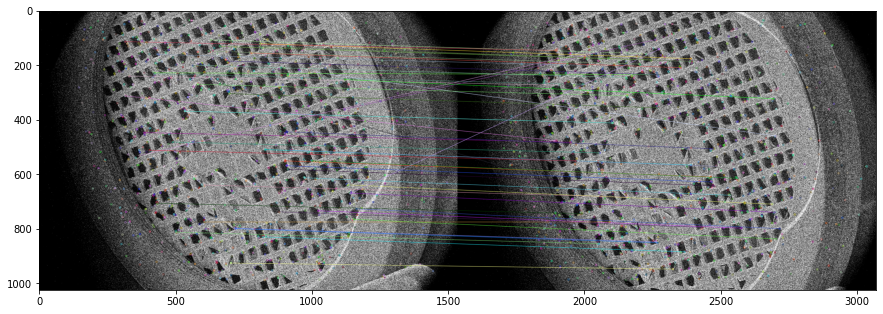

---Image Transformation---
[[ 9.98381933e-01 -4.40236390e-02  4.96384093e+01]
 [ 4.56916661e-02  9.98176167e-01  1.90878599e+01]
 [-1.59959351e-06  1.13308964e-06  1.00000000e+00]]

Translation (x,y) / mm: 0.15, 0.06
Translation (x,y) / px: 49.63840931746636, 19.08785990372524
Scaling (x,y): 0.9994269419476557, 0.9991465067000226
Rotation Angle (x,y, mean): 2.620159090550701, 2.5255288784014875, 2.57
Center of rotation / mm: 3.21002812085187, 1.31784261447709


Rotation: 7.5


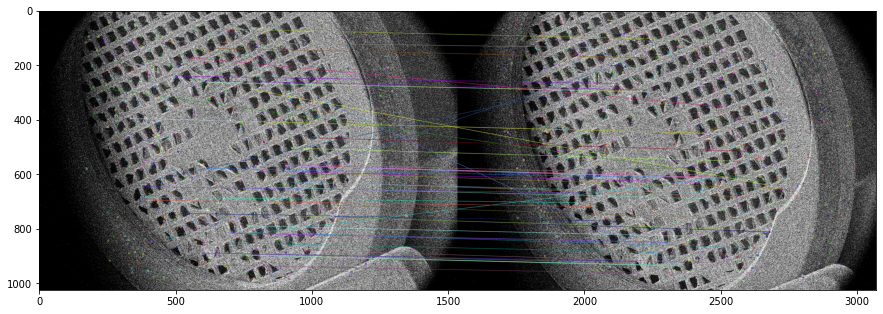

---Image Transformation---
[[ 1.00796864e+00 -4.48749506e-02  8.86557617e+01]
 [ 4.55759791e-02  1.00173869e+00  5.23741464e+00]
 [ 2.51272498e-06  2.60496307e-06  1.00000000e+00]]

Translation (x,y) / mm: 0.26, 0.02
Translation (x,y) / px: 88.65576171921683, 5.237414641860496
Scaling (x,y): 1.008998485094809, 1.0027433235818406
Rotation Angle (x,y, mean): 2.588855213135631, 2.5650159041946896, 2.58
Center of rotation / mm: 5.76629264748835, 0.470968718007022


Rotation: 10.0


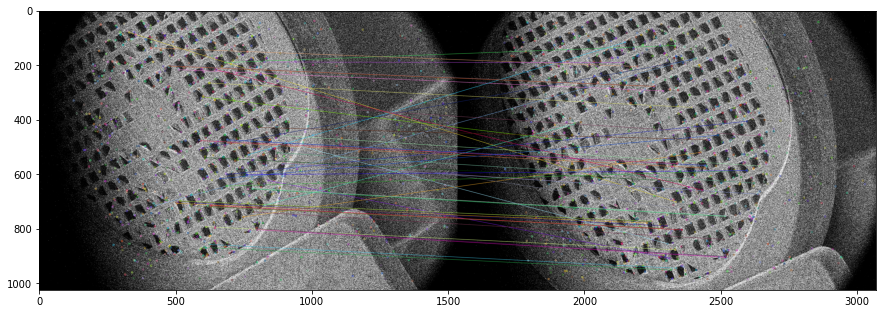

---Image Transformation---
[[ 1.01922452e+00 -1.02770198e-01  2.56413926e+02]
 [ 1.01758917e-01  9.96481007e-01  2.83235759e+01]
 [ 7.96902398e-06 -2.87462161e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.75, 0.08
Translation (x,y) / px: 256.4139261721391, 28.323575928931067
Scaling (x,y): 1.0242917058495762, 1.001766495184493
Rotation Angle (x,y, mean): 5.703365080519897, 5.886340668967678, 5.79
Center of rotation / mm: 7.37968582555014, 1.19535208638735


Rotation: 12.5


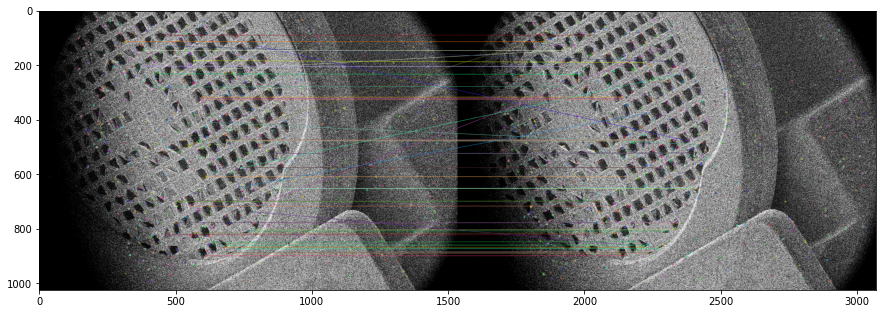

---Image Transformation---
[[ 9.99921506e-01  4.19179663e-03  1.36821797e-01]
 [-4.89081506e-03  9.99291311e-01  2.54293093e+00]
 [-1.13723561e-06 -2.36984915e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.00, 0.01
Translation (x,y) / px: 0.13682179653157225, 2.54293093353712
Scaling (x,y): 0.9999334669271198, 0.9993001026303211
Rotation Angle (x,y, mean): -0.280241937514171, -0.24034193460162434, -0.26
Center of rotation / mm: -0.0919593602500366, -1.63969832682525


Rotation: 15.0


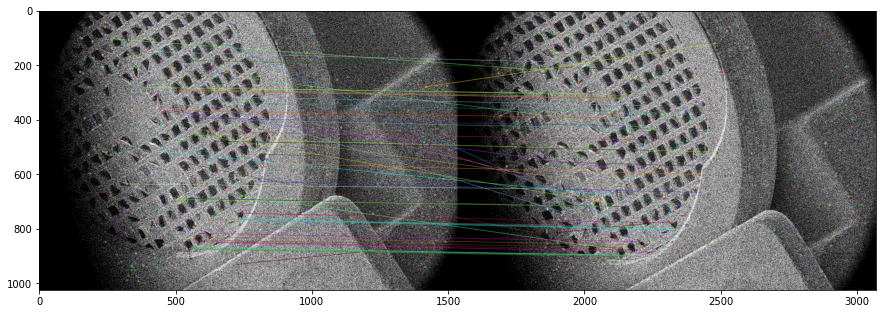

---Image Transformation---
[[ 1.00170061e+00 -4.99945039e-02  9.06291268e+01]
 [ 4.59981632e-02  9.93015219e-01  6.67171993e+00]
 [ 8.38404594e-07 -3.55035262e-06  1.00000000e+00]]

Translation (x,y) / mm: 0.27, 0.02
Translation (x,y) / px: 90.6291268105186, 6.671719926855677
Scaling (x,y): 1.0027561773290306, 0.9942729382212642
Rotation Angle (x,y, mean): 2.6297373894398164, 2.881577467972828, 2.76
Center of rotation / mm: 5.50976553550059, 0.539081797895974


Rotation: 17.5


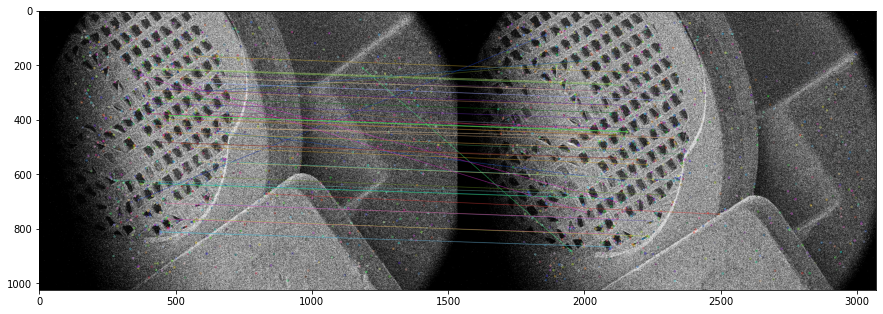

---Image Transformation---
[[ 9.93905143e-01 -4.89289176e-02  1.57641050e+02]
 [ 4.20425207e-02  9.93438866e-01  4.02572098e+01]
 [-8.77839883e-06  1.71841451e-06  1.00000000e+00]]

Translation (x,y) / mm: 0.46, 0.12
Translation (x,y) / px: 157.64104974927767, 40.25720981847613
Scaling (x,y): 0.994793951614659, 0.9946430610202147
Rotation Angle (x,y, mean): 2.4229550643753526, 2.818763294179607, 2.62
Center of rotation / mm: 10.0357390070450, 2.80883205032400


Rotation: 20.0


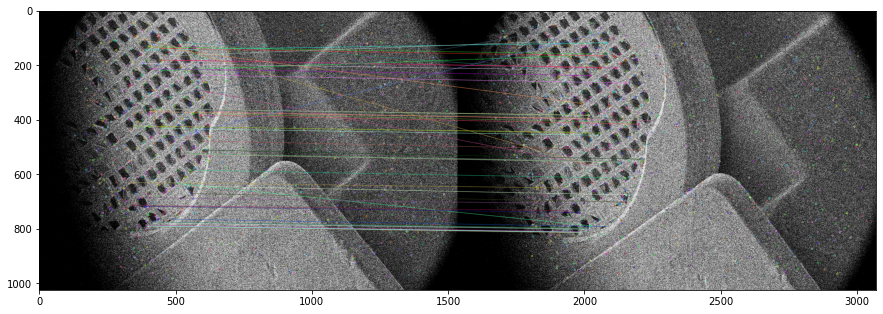

---Image Transformation---
[[ 9.81880241e-01 -4.55213700e-02  9.00695682e+01]
 [ 3.78884897e-02  9.87647608e-01  9.90686695e+00]
 [-2.12725205e-05 -1.71658762e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.26, 0.03
Translation (x,y) / px: 90.06956816182982, 9.906866953924542
Scaling (x,y): 0.9826109834066885, 0.9886961070220124
Rotation Angle (x,y, mean): 2.2105155073755802, 2.638099499587044, 2.42
Center of rotation / mm: 6.22096244898954, 0.817785651872727


Rotation: 22.5


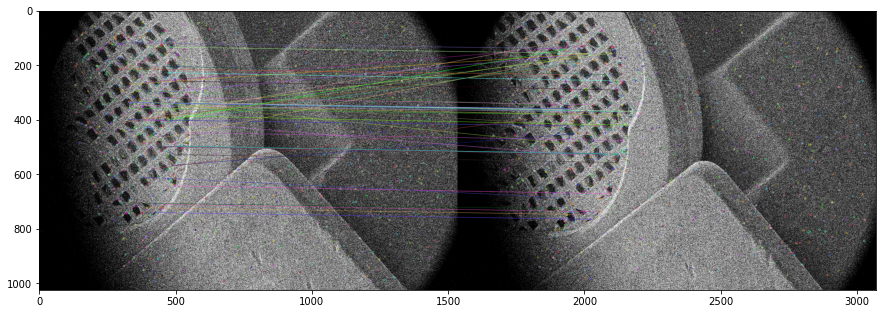

---Image Transformation---
[[ 1.02550424e+00 -4.68724519e-02  8.77205211e+01]
 [ 5.61482709e-02  1.00639167e+00  4.64916422e+00]
 [ 2.71210182e-05 -8.99921168e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.26, 0.01
Translation (x,y) / px: 87.72052105903467, 4.649164222050198
Scaling (x,y): 1.0270402027026229, 1.0074826106454053
Rotation Angle (x,y, mean): 3.1326296307236308, 2.6677107535044913, 2.9
Center of rotation / mm: 5.06927496106255, 0.397528022076534


Rotation: 25.0


IndexError: list index out of range

In [15]:
img_alignment = ()
corrected_img = ()
transformationMatrix = ()
params = ()
r = ()

delta_angle = 2.5

for _ in range(len(files)-1):    
    r += (delta_angle * ( _ + 1 ), )
    print("\n\nRotation: {}".format(r[_]))

    file_alignment = [f for f in files if '_'+ str(r[_]) in f]
    img_alignment += (cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE), )
    
    c_img, t_m = matchFeatures(img_reference=img_reference, img_to_align= img_alignment[_], DISPLAY_MATCHES=True) 

    if c_img is not None:
        corrected_img += (c_img,)
        transformationMatrix += (t_m,)   
        params += (get_params_from_transformation_matrix(transformationMatrix[_], pixe_size=pixel_size, PRINT=True), )
        img_reference = img_alignment[_]
    else:
        break
    _ += 1

# Plot angular diagram of angle and offsets

Text(0.5, 0, 'Measured image rotation angle / deg')

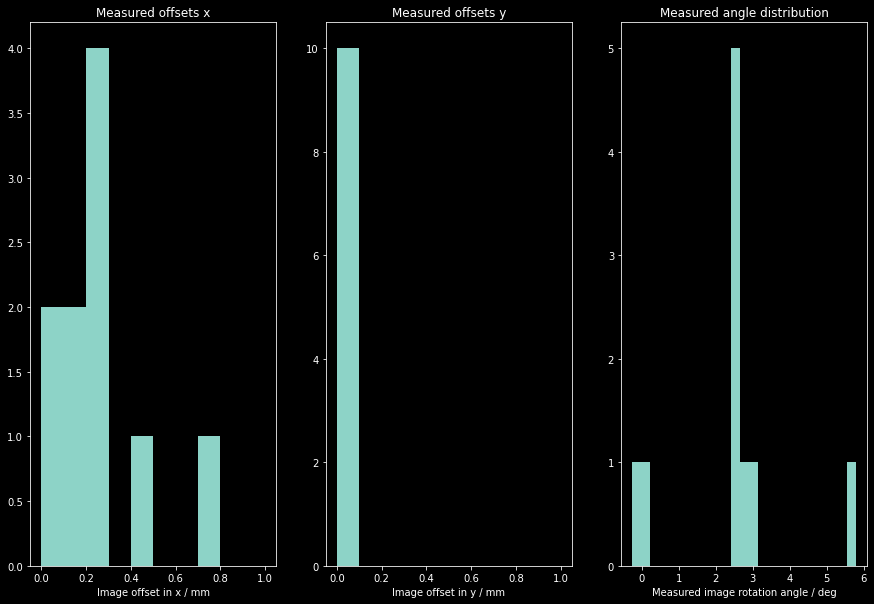

In [53]:
angles_measured = [0.]
x,y = [0.],[0.]
plt.style.use('dark_background')

for _ in range(len(params)):
    x.append(params[_]['t_meter'][0])
    y.append(params[_]['t_meter'][1])
    angles_measured.append(params[_]['phi'][2])
angles_measured, x, y

fig,ax = plt.subplots(1,3)
ax[0].hist([_ *1e3 for _ in x],bins=10, range=(0.0,1.0))
ax[0].set_title('Measured offsets x')
ax[0].set_xlabel('Image offset in x / mm')
ax[1].hist([_ *3 for _ in y],bins=10, range=(0.0,1.0))
ax[1].set_title('Measured offsets y')
ax[1].set_xlabel('Image offset in y / mm')
ax[2].hist(angles_measured, bins=25)
ax[2].set_title('Measured angle distribution')
ax[2].set_xlabel('Measured image rotation angle / deg')

#for i, txt in enumerate(angles_measured):
#    ax[0].annotate(str(round(txt,1)), (x[i], y[i]))

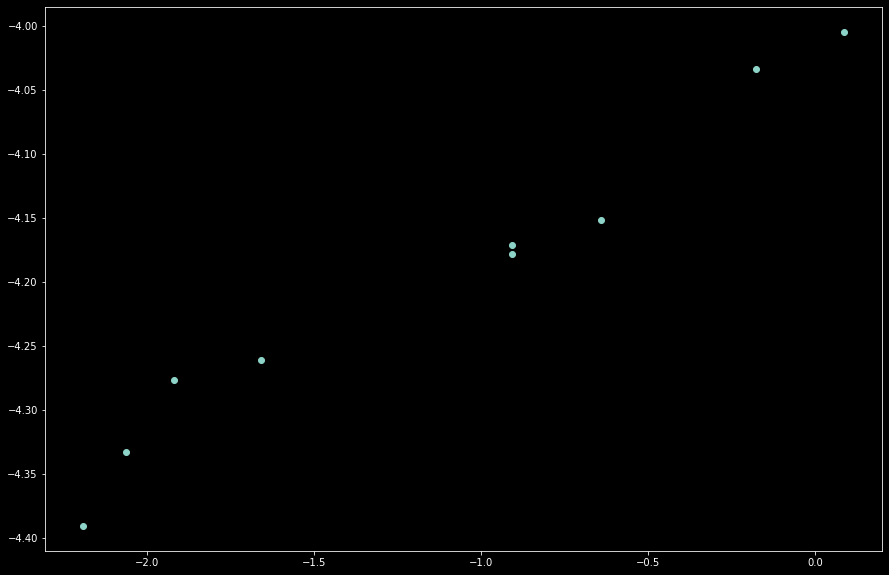

In [105]:
# Calculate positions
new_pos = []
x_sum, y_sum = 0.0, 0.0

for _ in range(len(positions_sorted)-1):
    i = len(positions_sorted) - _ -1
    new_pos.append(position_standard.copy())
    x_sum += x[_]
    y_sum += y[_]
    new_pos[_]['x'] -=  x_sum
    new_pos[_]['y'] -= y_sum
    new_pos[_]['r'] = positions_sorted[i]['r']

#new_pos

fig, ax = plt.subplots()
ax.scatter([_['x']*1e3 for _ in new_pos], [_['y']*1e3 for _ in new_pos])


In [57]:
from scipy import optimize

def calculate_center_lsq(x,y, VERBOSE= True):
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)

    if VERBOSE:
        print("Center: {},{}".format(xc_2,yc_2))
        print("Radius: {}".format(R_2))
        print("Residuum: {}".format(residu_2))

    return {'xc': xc_2, 'yc': yc_2, 'r': R_2, 'residuum': residu_2}

result_lsq = calculate_center_lsq(x,y)

Center: -0.2709135835335136,2.3231625240427713
Radius: 2.3388949874843172
Residuum: 7.0094074032600264e-09


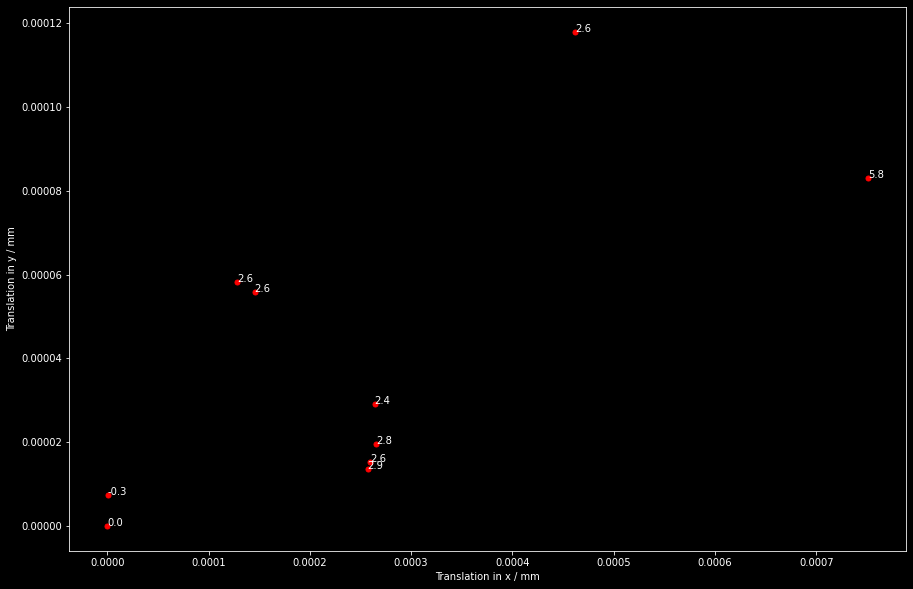

In [63]:
from ctypes import resize
from matplotlib.patches import Arc as arc
plt.style.use('dark_background')
fig, ax = plt.subplots()

ax.plot(x,y,'ro',linewidth=2, markersize=5)
for i, txt in enumerate(angles_measured):
    ax.annotate(str(round(txt,1)), (x[i], y[i]))

#ellipse = arc(xy=(result_lsq['xc'],result_lsq['yc']), width=2*result_lsq['r'], height=2*result_lsq['r'], angle=np.max(angles_measured),
#              theta1=-90-20, theta2=-90, edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
#ax.add_patch(ellipse)
#ax.axis('equal')

#ax.plot(result_lsq['xc'],result_lsq['yc'], 'go')
ax.set_xlabel('Translation in x / mm')
ax.set_ylabel('Translation in y / mm')
plt.show()

# Test Bed

In [ ]:
pos_rotation_aligned = positions[3]
print(pos_rotation_aligned)
pos_rotation = {'x': -2.1915e-3, 'y': -4.3908e-3, 'z':6.9725e-3, 't':0.0, 'r': r}

# Calculate the difference between the rotated and aligned position
rotation_difference = {key: float(pos_rotation_aligned[key] - pos_rotation.get(key, 0)) for key in pos_rotation_aligned}
print("Rot Diff: {}".format(rotation_difference))


rotation_difference_vector = np.array([[rotation_difference['x']], [rotation_difference['y']]])
print("Rot Diff Vector: {}".format(rotation_difference_vector))

rotation_matrix = get_rotation_matrix_inverse(r)
print("Rot Matrix: {}".format(rotation_matrix))

rotation_center = rotation_matrix * rotation_difference_vector
print("Rot Center mm: {}".format(rotation_center*1e3))

{'x': -0.002007875000000333, 'y': -0.0043908333333333325, 'r': 6.056242463482126, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}


TypeError: unsupported operand type(s) for -: 'float' and 'tuple'

In [ ]:
# Init running variables
deltaR = angle * math.pi / 180
itrations = 10
rotation_center = (.0,.0)  
pos_rotation = []
pos_rotation_aligned = []   
pos_estimated = []  
pos_alignment = []
pos_estimated_vector = []

pos_alignment = positions[0]
pos_alignment['x'] = -2.1915e-3
pos_alignment['y'] = -4.3908e-3
pos_alignment['z'] = 6.9725e-3
pos_alignment['t'] = 0.0
pos_alignment['r'] = 2*math.pi # radians!

printPositionNicely(pos_alignment)



In [ ]:
i = 0
# Estimate coordinates of rotated point with estimated center of rotation
matrix = get_rotation_matrix_offset(deltaR,rotation_center)
print(matrix)

pos_estimated_vector = np.dot(get_rotation_matrix_offset(deltaR,rotation_center),np.array([pos_alignment['x'], pos_alignment['y'],1]))
pos_estimated.append(pos_alignment.copy())
pos_estimated[i]['x'] = pos_estimated_vector[0]
pos_estimated[i]['y'] = pos_estimated_vector[1]
pos_estimated[i]['r'] = pos_alignment['r'] - deltaR

printPositionNicely(pos_estimated[0])

In [ ]:
print('Alignment:')
printPositionNicely(positions[2])

In [ ]:
# Kill kernel
#os._exit(00)

In [ ]:
#Take alignment image and save position
img_rotated = img_alignment.copy()
print(img_rotated.shape)

def correlateImages(img0, img1, VERBOSE = False):
    img0, img1 = np.float32(img0),np.float32(img1)
    #Align images and save the offset
    center_x, center_y, score = phase_correlate(np.float32(img_reference), np.float32(img_rotated))
    if VERBOSE:
        print("Center X / px: {}\nCenter Y / px: {}\nScore: {}\n".format(center_x,center_y, score))
        print("Center X / %: {}\nCenter Y / %: {}\n".format(center_x/img_reference.shape[1]*100,center_y/img_reference.shape[0]*100))
    return center_x, center_y, score


c_x, c_y, score = correlateImages(img_reference, img_rotated)

offset = []
offset.append(c_x - img_reference.shape[1]/2)
offset.append(c_y - img_reference.shape[0]/2)
print(offset)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_reference)
axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
axarr[0].plot(c_x,c_y,'go')
axarr[1].imshow(img_rotated) 
axarr[1].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')
axarr[1].plot(c_x,c_y,'go')

In [ ]:
height, width = np.shape(img_reference)[0], np.shape(img_reference)[1]
center = (width/2, height/2)
rotated_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
img_reference_rotated = cv2.warpAffine(src=img_reference, M=rotated_matrix, dsize=(width, height))

c_x, c_y, score = correlateImages(img_reference_rotated, img_rotated)

offset = []
offset.append(c_x - img_reference.shape[1]/2)
offset.append(c_y - img_reference.shape[0]/2)
print(offset)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img_reference)
axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
axarr[0].plot(c_x,c_y,'go')
axarr[0].set_title('Reference Image')
axarr[1].imshow(img_reference_rotated) 
axarr[1].plot(img_reference_rotated.shape[1]/2, img_reference_rotated.shape[0]/2,'ro')
axarr[1].plot(c_x,c_y,'go')
axarr[1].set_title('Reference Image, cv2-rotated by ' + str(angle))
axarr[2].imshow(img_rotated) 
axarr[2].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')
axarr[2].plot(c_x,c_y,'go')
axarr[2].set_title('Image after stage rotation by ' + str(angle))

In [ ]:
# Try to reduce offset as much as possible in three x-y-moves
move_count = 0
l_center_in_meters_x = offset[0] * pixel_size
l_center_in_meters_y = offset[1] * pixel_size
while score < 0.98 and move_count < 3:
    x = l_center_in_meters_x * -1  # sign may need to be flipped depending on matcher
    y = l_center_in_meters_y * -1
    distance = np.sqrt(x ** 2 + y ** 2)
    print("Deviation (in mm): " + str(distance*1e3))

    # move stage and reset beam shift
    print("Moving stage by ("+str(x)+","+str(y)+") and resetting beam shift...")

    
    transform = np.float32([ [1,0,-offset[0]], [0,1,-offset[1]]] )
    img_rotated = cv2.warpAffine(img_rotated, transform, (img_rotated.shape[1],img_rotated.shape[0]) )

    move_count += 1

    c_x, c_y, score = correlateImages(img_reference, img_rotated)

    offset[0] = c_x - img_reference.shape[0]/2
    offset[1] = c_y - img_reference.shape[1]/2
    l_center_in_meters_x = offset[0] * pixel_size
    l_center_in_meters_y = offset[1] * pixel_size

    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img_reference)
    axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
    axarr[1].imshow(img_rotated) 
    axarr[1].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')

#pos_rotation_aligned.append(self.getStagePosition())

# Calculate the difference between the rotated and aligned position
#rotation_difference = {key: pos_rotation_aligned[key] - pos_rotation.get(key, 0) for key in pos_rotation_aligned}
#rotation_difference_vector = np.array(rotation_difference['x'], rotation_difference['y'])

#rotation_center_new = self.get_rotation_matrix_inverse(angle) * rotation_difference_vector

#rotation_center = rotation_center + (rotation_center - rotation_center_new) * 0.75